# Multi-Layer Perceptron
### Lisanne Wallaard | s2865459
###### Leiden University, LIACS, Cognitive Modelling

This notebook is based on/an extension of the following [tutorial](https://clclab.github.io/FNCM/Lab4-MLP.html). I deleted and added some text, added code on places with "### YOUR CODE HERE ###" and answered the questions roughly in the blue boxes. The detailed answers can be found under the Section Results in the paper in the [GitHub repository](https://github.com/LisanneWallaard/CM_Final.git).


### Introduction
We will analyse *McCulloch-Pitts* units in more depth. Then, we will see how to combine many neurons to build feed-forward networks called multi-layer perceptrons.

We will need the [numpy](https://docs.scipy.org/doc/numpy/index.html), [pandas](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/), [MNE](https://mne.tools/stable/index.html), [scipy](https://www.scipy.org/), [pywt](https://pywavelets.readthedocs.io/en/latest/) and [sklearn](https://scikit-learn.org/stable/) libraries, as well as some functions that are defined in the `MLP.py` file and some objects loaded in the `EEG.py` file. The cell below takes care of all of this.

The following will appear:

```
Do you want to set the path: /root/mne_data as the default EEGBCI dataset path in the mne-python config [y]/n?
```

Simply press “y” (on your keyboard) and then “Enter”.

Make sure you have Wget and pip installed. Otherwise follow respectively the [Wget tutorial](https://www.jcchouinard.com/wget/#Download_Wget_on_Windows) or the [pip tutorial](https://pip.pypa.io/en/stable/installation/).

In [2]:
# Install missing package
!pip install mne

# Import packages
import numpy as np                     # algebra
import pandas as pd                    # data manipulation
import matplotlib.pyplot as plt        # plotting
import mne                             # EEG dataset
import scipy                           # scientific computing & signal processing
import pywt                            # wavelet transform
import random                          # shuffling lists
import sklearn                         # machine learning tools (feature selection)

# Download code from the FNCM github repository
!wget --no-cache {"https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/EEG.py"}
!wget --no-cache {"https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/MLP.py"}

# Import said code
import MLP
from MLP import MLP, plot_errors
import EEG
from EEG import full_epochs, cropped_epochs, EEG_imagery

You should consider upgrading via the 'C:\Users\lisan\anaconda3\python.exe -m pip install --upgrade pip' command.


--2023-01-04 15:21:13--  https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/EEG.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6168 (6,0K) [text/plain]
Saving to: 'EEG.py.8'

     0K ......                                                100%  576K=0,01s

2023-01-04 15:21:13 (576 KB/s) - 'EEG.py.8' saved [6168/6168]

--2023-01-04 15:21:13--  https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/MLP.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6593 (6,4K)

Extracting EDF parameters from C:\Users\lisan\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\lisan\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\lisan\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 45 events and 161 original time points ...
0 bad epo

## 1. Classification and regression

In supervised learning a training dataset $\{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$ is given, and the task is to find a function $y = f(x)$ such that the function is applicable to unknown patterns $x$. Based on the nature of $y$, we can classify those tasks into two classes:

- **Classification** is to assign a predefined label to an unknown pattern. For instance, given a picture of an animal, we need to identify if that picture is of a cat, a dog or a mouse. If there are two categories (or two classes), the problem is called binary classification; otherwise, it is multi-class classification. For the binary classification problem, there is a special case, where patterns of the two classes are perfectly separated by a hyperplane (see [Figure 1](#Figure-1)). We call the phenomenon *linear separability*, and the hyperplane *decision boundary*.

- **Regression** differs from classification in that what we need to assign to an unknown pattern is a real number, not a label. For instance, given the height and age of a person, can we infer their weight?

<a name="Figure-1"></a>
##### Figure 1: Example of linear separability
![Example of linear separability](https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/linear_sep.png)

## 2. Perceptron
A perceptron is a simplified neuron receiving inputs as a vector of real numbers, and outputting a real number (see [Figure 2](#Figure-2)).

<a name="Figure-2"></a>
##### Figure 2: Perceptron
![Perceptron](https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/perceptron.png)


<a name="Figure-3"></a>
##### Figure 3: Threshold binary activation function
![Threshold binary activation function](https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/thresbin.png)

$
f(z) = 
\begin{cases}
    1 & \text{if } z > 0 \\
    0 & \text{otherwise}
\end{cases}
$

<br>

Mathematically, a perceptron is represented by the following equation:

$$
y = f(w_1 x_1 + w_2 x_2 + ... + w_n x_n + b) = f(\mathbf{w}^{T}\mathbf{x} + b)
$$

where $\mathbf{w} = (w_1, ..., w_n)$ are weights, $b$ is a bias, $\mathbf{x} = (x_1, ..., x_n)$ are input nodes, and $f$ is an activation function.

<br>

We are going to implement and train a perceptron in this assignment. Have a look at the function definitions in the next code block.

- `sigmoid` and `binary_threshold` can be used as activation functions. For the present, we will use the threshold binary function for $f$ (see [Figure 3](#Figure-3)).

> Verify that the function `binary_threshold` implements this equation.

The other functions are defined as part of the `Perceptron` class. You can read about classes [here](https://www.w3schools.com/python/python_classes.asp) but you don’t need to worry about them too much -- examples of how to use the Perceptron functions are given in the next code blocks below.

- When a `Perceptron` object is created, it initializes a perceptron model with a vector of `weights` ($\mathbf{w}$), a `bias` term ($b$), and an `activation` function ($f$).

- The `compute_error` function computes the mean squared error of the perceptron model on a dataset. The mean squared error ($\text{MSE}$) and classification accuracy on a sample $D = \{(\mathbf{x}_1, y_1), ..., (\mathbf{x}_n, y_n)\}$ are respectively defined as

$$
\text{MSE} = \frac{1}{|D|} \sum_{\langle x, y\ \in\ D \rangle} (y - \hat{y})^2, \qquad \text{accuracy} = \frac{1}{n} \sum_{i=1}^n I_{y_i}(\hat{y}_i)
$$

where $I_u(v)$ is an identity function, which returns 1 if $u = v$ and 0 otherwise.

- The `train` function will train the perceptron model on a dataset for a given number of iterations. The `plot` function is used to visualize the progress of the model during training: it displays the dataset and the current decision boundary.

- The `update` function should apply the update for a single training instance. You need to complete the implementation of this function in the following exercises.

> ***Homework exercise 1***: Explain why the $\text{accuracy}$ is the same as $1 - \text{MSE}$ on a binary classification task. Hint: look at all possible values of $y$ and $\hat{y}$ rather than attempting algebraic manipulation. **(1pt)**

<div class="alert alert-block alert-info" role="alert">
<h3> Answer homework exercise 1 </h3><br>
In both formulas we iterate over all the elements in the sample. In the $\text{MSE}$ formula every true value is subtracted by the predicted value. The outcome of this subtraction is squared and all the outcomes are summed up. So, the results are zero when the prediction is correct, $(0-0)^2$ or $(1-1)^2$. The results are one when both values are different and thus when the prediction is not correct, $(0-1)^2$ or $(1-0)^2$. The $\text{accuracy}$ formula gives one when the predicted and actual value of the sample match, $(0=0)$ or $(1=1)$. The function gives zero when they are not the same and when the prediction, therefore, is wrong, $(0!=0)$ or $(1!=1)$. All these results are also summed up and are the exact opposite of what is calculated in $\text{MSE}$. As $\frac{1}{|D|} = \frac{1}{n}$, $\text{accuracy}$ is the same as $1 - \text{MSE}$ on a binary classification task.

### 2.1 Data & Model

We will start using a very simple dataset to train the perceptron model on: logical OR. This dataset consists of four training examples; have a look at it in the cell below.

In [3]:
# OR data
data_OR = pd.DataFrame(data={'x1': [1, 1, 0, 0], 
                             'x2': [1, 0, 1, 0],
                             'y': [1, 1, 1, 0]})
data_OR

,x1,x2,y
0,1,1,1
1,1,0,1
2,0,1,1
3,0,0,0


Now create a dataset for a different operation: XOR. Copy the code for the OR dataset from above, but change the values of **y** such that the dataset expresses the XOR operation.

In [4]:
# XOR data

### YOUR CODE HERE ###
data_XOR = pd.DataFrame(data={'x1': [1, 1, 0, 0], 
                             'x2': [1, 0, 1, 0],
                             'y': [0, 1, 1, 0]})

data_XOR

,x1,x2,y
0,1,1,0
1,1,0,1
2,0,1,1
3,0,0,0


We now implement the functions `sigmoid` and `binary_threshold`, and the `Perceptron` class. The `update` method, i.e. a function for the class, is not correctly implemented yet though: the model as it is learns nothing. We will look at how do it later on.
<a name="2.1-Model"></a>

In [5]:
# sigmoid function
def sigmoid(x):
    """
    Sigmoid function.
    
    Input:
      x -- an array
      
    Output:
      sigmoid(x) = 1/(1 + exp(-x))
    """
    return 1./(1. + np.exp(-x))

# binary threshold function
def binary_threshold(x):
    """
    Binary threshold function.
    
    Input:
      x -- an array
      
    Output:
      binary_threshold(x) = 1.0 if x > 0, else 0.0
    """
    return 1.*(x > 0)

### Perceptron model

class Perceptron:
    def __init__(self, dim, activation):
        """
        Initializes the perceptron -- sets weights, bias and
        activation function; returns the perceptron object.
        
        Input:
          dim -- dimensionality of the datapoints (integer)
          activation -- the desired activation function (function)
        """
        
        # initialize all weights and bias as zero
        self.weights = np.random.uniform(low=0., high=0., size=dim)
        self.bias = np.random.uniform(low=0., high=0., size=1)
        
        # activation function
        self.activation = activation
            
    def compute_error(self, X, y):
        """
        Computes the error of the perceptron with regard to the dataset.
        
        Input:
          X -- an (N, D) array in which each row is a data point
          y -- an (N, 1) array in which each row is the target of X[i,]
          
        Output:
          classification error (mean squared error)
        """
        
        # number of data points
        N = len(X)
        
        # compute mean squared error
        mse = np.sum((y.flatten() - \
                self.activation(X @ self.weights + self.bias))**2) / N
        
        return mse
    
    def plot(self, X, y, example_input):
        """
        Plot the data points and the (learned) decision boundary.
        """
        targets = y.flatten()
        wmin = -1.5
        wmax = 1.5
        
        # plot data points
        plt.plot(X[targets == 1, 0], X[targets == 1, 1], 'bo', ms=10)
        plt.plot(X[targets == 0, 0], X[targets == 0, 1], 'rs', ms=10)
        plt.xlim(wmin, wmax)
        plt.ylim(wmin, wmax)
        plt.xticks([0, 1])
        plt.yticks([0, 1])
        plt.xlabel('$x_1$', size=15)
        plt.ylabel('$x_2$', size=15)
        
        # plot circle around current example
        plt.scatter(example_input[0], example_input[1], marker='s',
                    color='none', edgecolor='g', s=400)
        
        # plot decision boundary
        if perceptron.weights[0] == 0. and perceptron.weights[1] == 0:
            pass
        elif perceptron.weights[1] == 0.:
            db_y = np.arange(start=wmin, stop=wmax, step=0.1)
            db_x = (-perceptron.bias - db_y*perceptron.weights[1]) / \
                    perceptron.weights[0]
            plt.plot(db_x, db_y, 'k-')
        else:
            db_x = np.arange(start=wmin, stop=wmax, step=0.1)
            db_y = (-perceptron.bias - db_x*perceptron.weights[0]) / \
                    perceptron.weights[1]
            plt.plot(db_x, db_y, 'k-')
        plt.show()
    
    def train(self, X, y, maxit=5, learn_rate=0.1, stepbystep=True):
        """
        Trains the perceptron -- iterates over a dataset and learns 
        online.
        
        Input:
          X -- an (N,D) array in which each row is a data point
          y -- an (N,1) array in which each row is the target of X[i,]
          maxit -- the number of iterations for training
          learn_rate -- the learning rate for training
          stepbystep -- wait for user to continue and print each step
          
        Output:
          errors -- error over the entire data after each iteration
        """
        errors = np.zeros(maxit)
        
        for it in range(0, maxit):
            if stepbystep:
                print('iteration', it+1)
            
            # pick training example
            i = it % len(X)
            example_input = X[i,:]
            example_target = y[i]
            
            # update perceptron
            self.update(example_input, example_target, learn_rate, stepbystep)
            
            if stepbystep:
                self.plot(X, y, example_input)
                inpt = input()
                if inpt == 'q':
                    print('Stopped after', it+1, 'iterations.')
                    break
            
            errors[it] = self.compute_error(X, y)
            
        return errors
    
    def update(self, example_input, example_target, learn_rate, stepbystep=True):
        """
        Applies a single update to the perceptron.
        
        Input:
          example_input -- an example datapoint (vector)
          example_target -- the corresponding target
          learn_rate -- the learning rate (real number)
          stepbystep -- whether to print the results
        """
        
        ### YOUR CODE HERE ###
        
        ## TODO: make proper prediction
        print(np.transpose(self.weights))
        print(example_input)
        
        pred = self.activation(np.sum(np.transpose(self.weights)*example_input) + self.bias)
        
        ## TODO: write update rules for weights and bias
        self.weights = self.weights + learn_rate*(example_target[0]-pred[0])*example_input
        self.bias = self.bias + learn_rate*(example_target[0]-pred[0])

        ######################
        
        if stepbystep:
            print('\tinput:', example_input)
            print('\ttarget:', example_target)
            print('\tprediction:', pred)
            print('\tweights:', self.weights)
            print('\tbias:', self.bias, '\n')

The code block below loads the data and runs the training for the perceptron. Use `stepbystep` to see the prediction and model parameters after each example. At the same time, a plot will appear to inform you which example (encased in the green box) is being taken, and what the current decision boundary (the black line) looks like. Press Enter inside the input field to go to the next iteration, and you may press “q” if you want to stop the code before the maximum number of iterations is reached.

If you run the code, you should now see that **the model is not learning the task yet**: you will not see a moving decision boundary. You need to implement the `update` function, which you can find in [the cell above](#2.1-Model): [Subsection 2.2](#2.2-Prediction) and [subsection 2.3](#2.3-Training) will tell you how.

weights: [0. 0.]
bias: [0.]
activation function: binary_threshold
iteration 1
[0. 0.]
[1 1]
	input: [1 1]
	target: [1]
	prediction: [0.]
	weights: [0.1 0.1]
	bias: [0.1] 



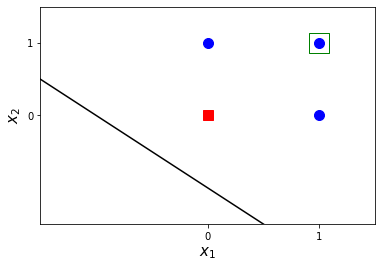


iteration 2
[0.1 0.1]
[1 0]
	input: [1 0]
	target: [1]
	prediction: [1.]
	weights: [0.1 0.1]
	bias: [0.1] 



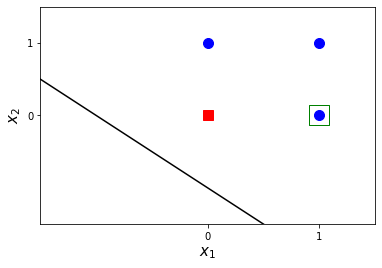


iteration 3
[0.1 0.1]
[0 0]
	input: [0 0]
	target: [0]
	prediction: [1.]
	weights: [0.1 0.1]
	bias: [0.] 



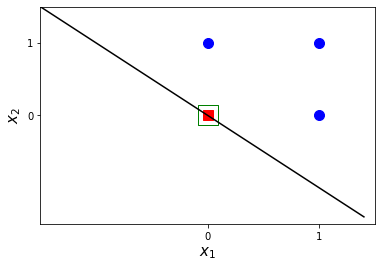


iteration 4
[0.1 0.1]
[0 1]
	input: [0 1]
	target: [1]
	prediction: [1.]
	weights: [0.1 0.1]
	bias: [0.] 



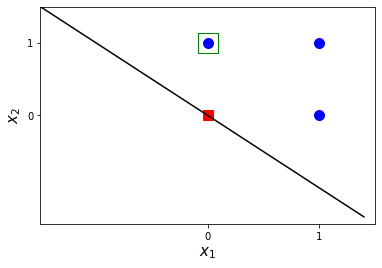


iteration 5
[0.1 0.1]
[1 1]
	input: [1 1]
	target: [1]
	prediction: [1.]
	weights: [0.1 0.1]
	bias: [0.] 



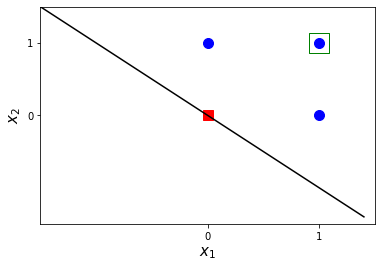

q
Stopped after 5 iterations.


array([0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  ])

In [13]:
# the data
# change between data_OR and data_XOR based on what you want to learn
data = data_OR
#data = data_XOR

# shuffle data
np.random.shuffle(data.values)
X = data[['x1', 'x2']].values
y = data[['y']].values
input_size = X.shape[1]

# initialize the perceptron
perceptron = Perceptron(dim=input_size,
                        activation=binary_threshold)

# print model attributes before training
print('weights:', perceptron.weights)
print('bias:', perceptron.bias)
print('activation function:', perceptron.activation.__name__)

# train perceptron
perceptron.train(X, y,
                 maxit=15,
                 learn_rate=0.1,
                 
                 stepbystep=True)

<a name="2.2-Prediction"></a>
### 2.2 Prediction

A new pattern $\mathbf{x}$ will be assigned the label $\hat{y} = f(\mathbf{w}^T \mathbf{x} + b)$.

Look at the code block above that implements the Perceptron class and find the corresponding variables in the code for all elements of the mathematical notation. What are the variable names for the weights ($\mathbf{w}$), the bias term ($b$), an example input pattern ($\mathbf{x}$), and the activation function $f$, in the provided Python code?

> Rewrite the “`pred = 0`” line in the `update` function of the perceptron model, such that the variable `pred` gets assigned the appropriate value according to this equation. 
Hint: you may want to use the [`np.sum`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html) function which returns the sum of all its input values.

<a name="2.3-Training"></a>
### 2.3 Training

Traditionally, a perceptron is trained in an online-learning manner with the delta rule: we randomly pick an example $(\mathbf{x}, y)$ and update the weights and bias as follows:

$$
\mathbf{w}_\text{new} \leftarrow \mathbf{w}_\text{old} + \eta(y - \hat{y}_\text{old})\mathbf{x} \\
b_\text{new} \leftarrow b_\text{old} + \eta(y - \hat{y}_\text{old})
$$

where $\eta$ is a learning rate ($0 < \eta < 1$), $\hat{y}_\text{old}$ is the prediction based on the old weights and bias.

> Implement these weight update rules in the `update` function of the perceptron model, by rewriting these lines in the code cell:

        self.weights = self.weights ## + ...
        self.bias = self.bias ## + ...
        
The weights and bias are only updated if the prediction $\hat{y}_\text{old}$ is different from the true label $y$, and the amount of update is (negatively, in the case $y = 0$) proportional to $\mathbf{x}$. Intuitively, the update is to pull the decision boundary to a direction that makes the prediction on the example “less incorrect” (see [Figure 4](#Figure-4)). It can be proven that if the training dataset is linearly separable, the perceptron is guaranteed to find a hyperplane that correctly separates the training dataset (i.e., error = 0) in a finite number of update steps. Otherwise, the training won’t converge.

<a name="Figure-4"></a>
##### Figure 4: Example of weight update
The chosen example is enclosed in the green box. The update pulls the plane to a direction that makes the prediction on the example “less incorrect”.

![Example of weight update](https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/update_w.png)

#### Training on OR
Now train your model on the OR data to learn the logical OR operation: re-run the code block that defines the perceptron functions (with your rewritten `update` function), and then re-run the code block for training the perceptron. Make sure you understand how the model learns by computing the prediction and update yourself (on paper) for each time step.

> ***Homework exercise 2***: In how many iterations does the training converge? Does the answer depend on the order of the examples? Explain. **(1pt)**

<div class="alert alert-block alert-info" role="alert">
<h3> Answer homework exercise 2 </h3><br>
After running the training a couple of times, the training coverges almost everytime in a different number of iterations. It varies between 2 and 9 iterations. These iterations have a different order of input examples before resulting in the correct decision boundary. However, the answer, the correct decision boundary (containing the weights [0.1 0.1] and bias [0]), is every time the same. Therefore the answer does not depend on the order of the examples.

#### Training on XOR
Now train a perceptron model on your XOR data. In the code block for training the perceptron, rewrite the line `data = data_OR` so that it loads the XOR dataset that you created.

> ***Homework exercise 3***: What can you conclude about the convergence of training? Explain the observed behaviour. **(1pt)**

<div class="alert alert-block alert-info" role="alert">
<h3> Answer homework exercise 3 </h3><br>
The training does not converge into one certain linear plane. It keeps adjusting the plane as it does not find the correct one. That is because the data is not linearly separable. Therefore, the single-layer perceptron model is not able to create a linear plane that can separate the targets of the XOR data.

## 3. Multi-layer perceptron

The perceptron model presented above is very limited: it is theoretically applicable only to linearly separable data. In order to handle non-linearly separable data, the perceptron is extended to a more complex structure, namely the multi-layer perceptron (MLP). An MLP is a neural network in which neuron layers are stacked such that the output of a neuron in a layer is only allowed to be an input to neurons in the upper layer (see [Figure 5](#Figure-5)). Informally speaking, a neuron is activated by the sum of weighed outputs of the neurons in the lower layer. It turns out that, if the activation functions of those neurons are non-linear, such as the sigmoid (or logistic) function (see [Figure 6](#Figure-6)):

$$
\text{sigm}(z) = \frac{1}{1 + e^{-z}}
$$

then the MLP can capture high non-linearity of data: it can be proven that we can approximate any continuous function at an arbitrary small error by using complex-enough MLPs.

<a name="Figure-5"></a>
##### Figure 5: A 3-layer perceptron with 2 hidden layers
(from http://www.statistics4u.com/fundstat_eng/cc_ann_bp_function.html)

![A 3-layer perceptron with 2 hidden layers](https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/multil_perceptron.png)

<br>

<a name="Figure-6"></a>
##### Figure 6: Sigmoid activation function

![Sigmoid activation function](https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/sigmoid.png)

### 3.1 Prediction

Prediction is very fast thanks to the *feedforward* algorithm ([Figure 7](#Figure-7), on the left). The algorithm says that, given $\mathbf{x}$, we firstly compute the outputs of the neurons in the first layer; then we compute the outputs of the neurons in the second layer; and so on until we reach the top layer.

<a name="Figure-7"></a>
##### Figure 7: Feedforward (left) and backpropagation (right)
![Feedforward (left) and backpropagation (right)](https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/feedforward_backprop.png)

### 3.2 Training

Training an MLP is to minimize an objective function, which is related to the task that the MLP is used for. For instance, for the binary classification task, the following objective function is widely used:

$$
J(\theta) = \frac{1}{n} \sum_{(\mathbf{x}, y)\ \in\ D} (y - \hat{y})^2
$$

where $D$ is a training dataset, $\hat{y}$ is the output of the MLP given an input $\mathbf{x}$ and $\theta$ is its set of weights and biases. In order to minimize the objective function $J(\theta)$, we will use the *gradient descent* method (see [Figure 8](#Figure-8)) which says that an amount of update for a parameter is negatively proportional to the gradient at its current value.

<a name="Figure-8"></a>
##### Figure 8: Illustration for the gradient descent method
The blue line is the tangent at the current value of the parameter $w$. If we update $w$ by subtracting an amount proportional to the gradient at that point, the value of $E$ will be pushed along the arrow and hence decrease. However, this method only guarantees to converge to a local minimum.

![Illustration for the gradient descent method](https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/gradient_descent.png)

We will now train a multi-layer perceptron on the OR and XOR data. The MLP itself is already implemented for you, as well as the feedforward and backpropagation algorithms for training it (if you want, you can have a look at the code in the `MLP.py` file). Here we will just load the MLP and experiment with a few settings. When you execute the codeblock below, you will see the MLP’s final accuracy on the training dataset, in addition to a plot of the progress over training. This plot shows the *weighed sum of squared errors* at each iteration:

$$
\text{weighed SSE} = \sum_{\langle x, y \rangle\ \in\ D} \frac{1}{\big|\{\langle x', y' \rangle\ \in\ D : y' = y \}\big|} (y - \hat{y})^2
$$

It is different from the MSE that we saw earlier. For one, it computes the sum instead of the mean of the errors. Secondly, the sum is weighed with respect to the class sizes. In many datasets, the size of the different classes varies. There may be more pictures of cats than of dogs, for instance. The weighing factor compensates for this, so that a model that always predicts “cat” has no better performance than a model that always outputs “dog”.

#### Train an MLP
Now train the MLP on the OR and XOR datasets by changing and executing the code block below. Experiment by varying the number of iterations, the learning rate, and the number of hidden nodes in order to answer the homework exercises below.

Final accuracy: [1.]


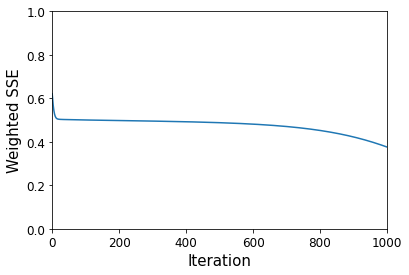

In [7]:
# the data
# change between data_OR and data_XOR based on what you want to learn
data = data_XOR

# set a seed to get the same plot
# np.random.seed(1000)

# shuffle data
np.random.shuffle(data.values)
X = data[['x1', 'x2']].values
y = data[['y']].values
input_size = X.shape[1]

# initialize the MLP
mlp = MLP(n_input=input_size, 
          n_hidden=5, 
          n_output=1)

# train the MLP on the dataset
errors = mlp.train(X, y, 
                   learn_rate=0.2,
                   maxit=1000)

# make predictions on the training dataset
predictions = np.array([mlp.predict(X[i,]) for i in range(len(X))])

# compute final accuracy
accuracy = sum((predictions > 0.5).astype(int) == y) / len(y)
print('Final accuracy:', accuracy)

# plot weighed SSE over iterations
plot_errors(errors, 'Weighed SSE')

> ***Homework exercise 4***: Find a minimum number of iterations such that the accuracy is 1 for the OR data, then change the learning rate and/or the number of hidden nodes twice and report all results. Can you make any qualitative, simple observations about what you see from this experiment? **(1.5pt)**

> ***Homework exercise 5***: How many hidden nodes do you minimally need to learn the XOR function? **(0.5pt)** Motivate your answer with a theoretical explanation **(0.5pt)** and an empirical validation. **(0.5pt)**

<div class="alert alert-block alert-info" role="alert">
<h3> Answer homework exercise 4 </h3><br>
The accuracy is stable around 1 when setting the number of iterations to 400. However, when setting a seed, iteration 206 is the first one to give a final accuracy of 1. After increasing and decreasing the learning rate and the number of hidden layers, it seems the higher the learning rate and the number of hidden nodes, the faster the training converges to a low weighed SSE and reaches an accuracy of 1. See the paper for the plots.

<div class="alert alert-block alert-info" role="alert">
<h3> Answer homework exercise 5 </h3><br>
Theoretically, just two hidden nodes should be enough. One hidden layer will operate as an OR gate and the other as a NOT AND gate. If both of these are true, then the output is also true. I indeed found, after running the cell a couple of times without seed, an outcome with an accuracy of 1. 

## 4. Training on EEG data

We will now look at how well the MLP can be trained to classify data that we did not create ourselves, but which were recorded from brain activity. We will use a dataset from the [MNE](https://mne.tools/stable/index.html) library, which is well-known and widely used for the analysis of neurophysiological data in Python. The dataset (EEGBCI, described at [PhysioNet](https://www.physionet.org/content/eegmmidb/1.0.0/)) contains EEG recordings on various tasks, including a *motor imagery* task: subjects were instructed to imagine moving either their hands or their feet, given some visual cue. We will use the data from one participant performing this task, in 45 trials (21 for hands, 24 for feet), while EEGs were recorded from 64 electrodes across the scalp. First we load the data.

We have loaded the EEG data from 0.5 seconds before the visual cue was presented, until 0.5 seconds after it was presented. The plots below show the raw EEG data for each of the 64 channels, averaged over trials, with the cue presentation at $t = 0$. Can you see the difference in EEGs between when the subject was thinking of moving their hands vs. moving their feet?

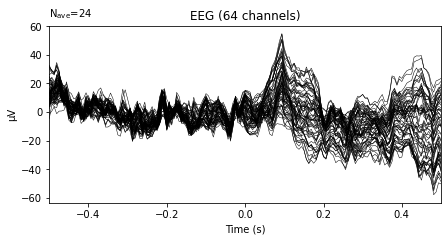

In [8]:
feet_plot = full_epochs['feet'].average().plot()

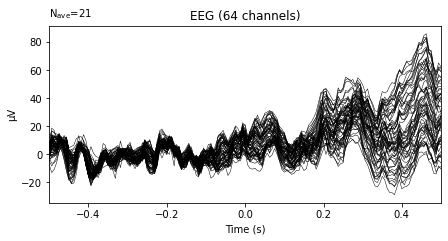

In [9]:
hands_plot = full_epochs['hands'].average().plot()

We want to see whether the MLP and perceptron can also learn to distinguish these patterns, and thereby predict from an EEG signal which extremities a subject is imaginarily moving. 
For this we will only use the signals from the point where the subject was actually imagining the movement ($t = 0$). Furthermore, we don’t use _all_ datapoints in the raw EEG signal; instead, we compute some features with which we aim to capture the most important information about the wave. For our toy problem, it turns out that an extremely crude encoding of this information will do.

We intend to capture some of the temporal properties of the EEG signal (how the wave changes over time), as well as some spectral properties (how intense the signal is in different frequency bands).

For the *temporal properties*, we divide the y-axis range of the EEG signal into 3 quantiles (in the plot below, the regions divided by the grey horizontal lines). From every raw EEG wave (the black line), we first remove the noise (giving the blue line), and then compute the average of the transformed signal at a few evenly spread points (blue dots). For each of those dots, we add a 0, 1 or 2 to our list of features depending on what quantile they fall in. Hence, the list of temporal features encoding the signal below would be `[0, 1, 1, 0, 0, 0, 1, 2, 2, 2, 2]`. The quantiles are computed separately for each channel of every epoch, such that there will be an approximately equal number of points in each of the three ranges — the 0s, 1s and 2s therefore (very crudely!) encode the _relative_ upward and downward movement of the wave over time.

<img src="https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/tempf.png" alt="Temporal feature extraction" width="800"/>

For the *spectral properties*, we look at three different frequency bands: theta (3.5 - 7.5 Hz), alpha (7.5 - 13 Hz) and beta (14+ Hz). We want to encode the relative distribution of spectral power density in these three bands: which frequency band contains most movement, and which the least? Again, we encode this using 0, 1 and 2: this time, the numbers mean “least”, “middle” and “most” spectral power density. The plot below shows the spectral power density for different frequency ranges across the entire signal timeframe. For this signal, the alpha band has the highest power density, followed by theta and finally beta. The list of spectral features encoding this signal would therefore be `[1, 2, 0]`.

<img src="https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/specf.png" alt="Spectral feature extraction" width="800"/>

Ultimately, we select the best of all spectral and temporal features across trials, such that we end up with a list of 96 numbers (all 0s, 1s and 2s) encoding the EEG signal per trial. You don’t need to understand the specifics of the feature extraction and selection procedure (although you can have a look in the `EEG.py` file if you’re curious), but you can probably see that these features omit a lot of information from the EEG signal. Maybe you can even already think of better ways to represent this information. Nevertheless, these very crude representations may still provide enough information for the MLP to learn to distinguish between imagined hand or foot movement.

To see how well the MLP model can learn to do this classification, we split the data into a training and a test set: we will train the model on two thirds of the data, and then test its prediction accuracy on the other third. As such, we evaluate how well the learned decision boundary (in this case a manydimensional hypersurface) will generalize to correctly classify unseen data: this method of model validation is called _cross-validation_.

In [10]:
# shuffle data
idx = list(range(len(EEG_imagery['trial_numbers'])))
random.shuffle(idx)
EEG_imagery['trial_numbers'] = EEG_imagery['trial_numbers'][idx]
EEG_imagery['features'] = EEG_imagery['features'][idx]
EEG_imagery['labels'] = EEG_imagery['labels'][idx]

# split 2/3 to train & test set
trials_train = EEG_imagery['trial_numbers'][:30]
trials_test = EEG_imagery['trial_numbers'][30:]
X_train = EEG_imagery['features'][:30]
X_test = EEG_imagery['features'][30:]
y_train = EEG_imagery['labels'][:30]
y_test = EEG_imagery['labels'][30:]

The code block below trains the MLP, plots the error over training and prints the final accuracy on the test set.

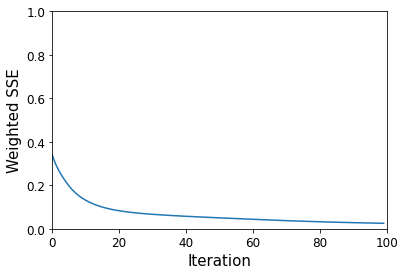

Final accuracy: 0.8666666666666667


In [24]:
# train MLP & plot training error
mlp = MLP(n_input=96, 
          n_hidden=5, 
          n_output=1)

errors = mlp.train(X_train, y_train, 
                   maxit=100, learn_rate=0.1)

plot_errors(errors, 'Weighed SSE')

# make predictions on test set
predictions = np.array([mlp.predict(X_test[i]) for i in range(len(X_test))]).flatten()
accurate = ((predictions > 0.5).astype(int) == y_test)
accuracy = sum(accurate) / len(y_test)
print('Final accuracy:', accuracy)

> ***Homework exercise 6***: 
Train the MLP on the EEG dataset a few times while varying the parameters; you can vary the number of hidden nodes and the training parameters `maxit` and `learn_rate`.
>
>A. Run the training several times with the same settings. Do you get the same results every time? Why or why not? **(0.5pt)**
>
>B. Training on the EEG data, how does the number of hidden nodes relate to the accuracy? Note: for proper empirical justification, you need to take the average over several runs. You may include a table or a plot to report your findings. **(1pt)**
>
>C. What can you conclude about the relation between convergence speed, learning rate and number of hidden nodes? **(1.5pt)**

<div class="alert alert-block alert-info" role="alert">
<h3> Answer homework exercise 6 </h3><br>
    
- A. I did not get the same results every time I ran the training with the same settings. We see in the MLP.py file that the weights and biases have been initialised using np.random.uniform(). As there is no seed, these values are different every time. Therefore, the outcome is different as well every training.
- B. See cell blocks below. The average accuracy quickly goes up until two nodes and then stabilises around 85\%. Sometimes the average accuracy is a bit higher, but it does not exceed 90\%. Keep in mind that you do not want to make the network unnecessarily complicated by adding too many nodes without much improvement in accuracy.
- C. I increased both the learning rate and the number of hidden layers separately. It seems the higher both variables (especially the learning rate), the higher the convergence speed as the weighed SSE decreases faster. See the paper for the plots. 

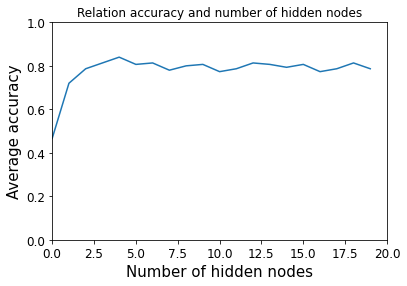

In [14]:
# train MLP & plot training error
acc = np.empty(20)
for n in range(20):
    acc_sum = 0
    for i in range(10):
        mlp = MLP(n_input=96, 
                  n_hidden=n, 
                  n_output=1)

        errors = mlp.train(X_train, y_train, 
                           maxit=100, learn_rate=0.1)

        # make predictions on test set
        predictions = np.array([mlp.predict(X_test[i]) for i in range(len(X_test))]).flatten()
        accurate = ((predictions > 0.5).astype(int) == y_test)
        acc_sum += sum(accurate) / len(y_test)
    accuracy = acc_sum/10
    acc[n] = accuracy
    

plt.plot(acc)
plt.xlim(0, acc.size)
plt.ylim(0, 1)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Average accuracy', size=15)
plt.xlabel('Number of hidden nodes', size=15)
plt.title('Relation accuracy and number of hidden nodes')
plt.show()

In [42]:
nodes = np.arange(0, 20, 1)
for n, a in zip(nodes, acc):
    print("{} = {}".format(n, a))

0 = 0.39999999999999997
1 = 0.7933333333333334
2 = 0.8533333333333335
3 = 0.8600000000000001
4 = 0.8866666666666667
5 = 0.8600000000000001
6 = 0.8933333333333333
7 = 0.86
8 = 0.8333333333333334
9 = 0.8800000000000001
10 = 0.8733333333333334
11 = 0.8733333333333334
12 = 0.8533333333333333
13 = 0.8533333333333335
14 = 0.8800000000000001
15 = 0.8933333333333335
16 = 0.8533333333333333
17 = 0.8866666666666669
18 = 0.8666666666666666
19 = 0.8733333333333334


If your model does not achieve 100% accuracy on the test set, it can be worth exploring the specific test set items that led to an incorrect prediction: can we find the reason that the MLP assigned these trials to the wrong class? Do they also look particularly confusing to us?

The cells below plot the EEG trials assigned to the _training set_, i.e. the epochs based on which the MLP learned to distinguish hands vs. feet in the motor imagery data. Note that the epochs here are cropped from the moment of cue presentation $(t = 0)$. We again separately plot the training set epochs (averaged over trials) for imagined feet movement vs. imagined hand movement.

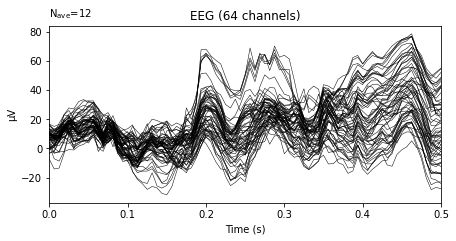

In [52]:
# Plot epochs in training set for feet (labeled 0)
feet_trials = trials_train[np.where(y_train == 0)]
train_feet_plot = cropped_epochs[feet_trials].average().plot()

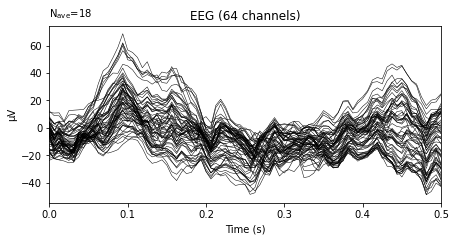

In [53]:
# Plot epochs in training set for hands (labeled 1)
hands_trials = trials_train[np.where(y_train == 1)]
train_hands_plot = cropped_epochs[hands_trials].average().plot()

Now, for which _unseen_ epochs did the MLP not manage to make a correct prediction? The code below separately plots the EEG data for each _misclassified_ trial in the _test set_.

Trial: 34
Prediction: 1
Correct label: 0


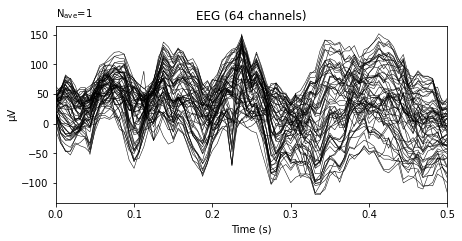

Trial: 15
Prediction: 1
Correct label: 0


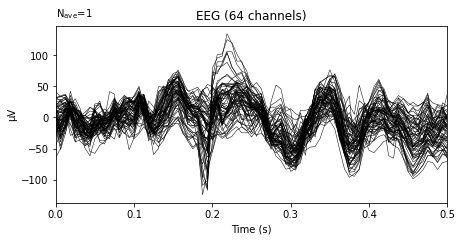

In [54]:
prediction_mistakes = np.where(accurate == False)[0]
for idx in prediction_mistakes:
    print('Trial:', trials_test[idx])
    print('Prediction:', (predictions[idx] > 0.5).astype(int))
    print('Correct label:', y_test[idx])
    cropped_epochs[trials_test[idx]].average().plot()

> ***Homework exercise 7***: Explore some misclassified epochs from an MLP trained with the default settings (5 hidden nodes, 100 iterations, learning rate 0.1). Can you see why the MLP made a mistake? Explain your observations, and include the epoch plots as illustration. **(1pt)**

<div class="alert alert-block alert-info" role="alert">
<h3> Answer homework exercise 7 </h3><br>
When looking at the averaged training set epochs for the imagined movements, we see that the electrical currents for the imagined hand movement are relatively high at 0.1s and low at 0.3s compared to the imagined feet movement. The EEG signals of the imagined hand movement also end lower than the EEG recordings of the imagined feet movement. When a trial has features of both these imagined movements, it is difficult for the MLP to choose the correct label and the MLP is more likely to make a mistake. It is expected that this is the case for the misclassified epochs. See the paper for the illustrations and more detailed explanation of the misclassified epochs. 